In [11]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

def set_seed(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed()

In [12]:
train_images = np.load("quickdraw_subset_np/train_images.npy")  # (N_train, 28, 28)
train_labels = np.load("quickdraw_subset_np/train_labels.npy")  # (N_train,)
test_images = np.load("quickdraw_subset_np/test_images.npy")    # (N_test, 28, 28)
test_labels = np.load("quickdraw_subset_np/test_labels.npy")

# Normalise to [0,1] and add channel dimension
train_images = (train_images.astype(np.float32) / 255.0)[:, None, :, :]
test_images = (test_images.astype(np.float32) / 255.0)[:, None, :, :]

val_split = 0.1
n_total = train_images.shape[0]
idx = int(n_total * (1 - val_split))

val_images, val_labels = train_images[idx:], train_labels[idx:]
train_images, train_labels = train_images[:idx], train_labels[:idx]

train_ds = TensorDataset(torch.from_numpy(train_images), torch.from_numpy(train_labels))
val_ds = TensorDataset(torch.from_numpy(val_images), torch.from_numpy(val_labels))
all_ds = TensorDataset(torch.from_numpy(np.concatenate([train_images, test_images], 0)),
                       torch.from_numpy(np.concatenate([train_labels, test_labels], 0)))

BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [13]:
class LSTMVariationalAutoencoder(nn.Module):
    def __init__(self, hidden_dim: int = 128, num_layers: int = 2, latent_dim: int = 32):
        super().__init__()
        self.seq_len = 28
        self.input_dim = 28
        self.latent_dim = latent_dim

        self.encoder_lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=self.input_dim,
            num_layers=num_layers,
            batch_first=True,
        )

    # encode using lstm
    def encode(self, x):      # (B, 1, 28, 28)
        x_seq = x.squeeze(1)  # (B, 28, 28)
        out, (h_n, _) = self.encoder_lstm(x_seq)
        z_mu = self.fc_mu(h_n[-1])  # (B, latent_dim)
        z_logvar = self.fc_logvar(h_n[-1])
        return z_mu, z_logvar
    
    def reparameterize(self, z_mu, z_logvar):
        std = torch.exp(z_logvar / 2)
        eps = torch.randn_like(std)
        z = z_mu + eps * std
        return z

    # decode using lstm
    def decode(self, z):
        batch_size = z.size(0)
        dec_init = self.fc_dec(z).unsqueeze(1)  # (B, 1, hidden)
        dec_in = dec_init.repeat(1, self.seq_len, 1)  # feed same vector each step
        out, _ = self.decoder_lstm(dec_in)
        out = out.reshape(batch_size, 1, 28, 28)  # reshape to image
        return out

    def forward(self, x):
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterize(z_mu, z_logvar)
        x_recon = self.decode(z)
        return x_recon, z_mu, z_logvar, z

In [14]:
class ConvVariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim: int = 32):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, stride=2, padding=0),
            nn.ReLU(inplace=True),
        )
        self.fc_mu = nn.Linear(64 * 3 * 3, latent_dim)
        self.fc_logvar = nn.Linear(64 * 3 * 3, latent_dim)

        self.fc_dec = nn.Linear(latent_dim, 64 * 3 * 3) # fc layer before decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def reparameterize(self, z_mu, z_logvar):
        std = torch.exp(z_logvar / 2)
        eps = torch.randn_like(std)
        z = z_mu + eps * std
        return z

    def encode(self, x):
        batch_size = x.size(0)
        h = self.encoder(x)
        h = h.view(batch_size, -1)
        z_mu = self.fc_mu(h)
        z_logvar = self.fc_logvar(h)
        return z_mu, z_logvar

    def decode(self, z):
        batch_size = z.size(0)
        h = self.fc_dec(z).view(batch_size, 64, 3, 3)
        x_hat = self.decoder(h)
        return x_hat

    def forward(self, x):
        z_mu, z_logvar = self.encode(x)
        z = self.reparameterize(z_mu, z_logvar)
        x_recon = self.decode(z)
        return x_recon, z_mu, z_logvar, z


In [15]:
def vae_loss(x, x_recon, z_mu, z_logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction="mean")
    kld = -0.5 * torch.mean(1 + z_logvar - z_mu.pow(2) - z_logvar.exp())
    return recon_loss + kld, recon_loss, kld


In [16]:
def train_autoencoder(model: nn.Module, train_loader, val_loader, num_epochs: int = 20):
    criterion = vae_loss
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    history = {"train": [], "val": []}

    for epoch in tqdm(range(1, num_epochs + 1)):
        model.train()
        train_loss = 0.0
        # forward, backward and step for each bach
        for imgs, _ in train_loader:
            optimizer.zero_grad()
            recon, z_mu, z_logvar, z = model(imgs)
            loss, recon_loss, kld = criterion(imgs, recon, z_mu, z_logvar)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * imgs.size(0)
        train_loss /= len(train_loader.dataset)


        model.eval()
        val_loss = 0.0
        # validation
        with torch.no_grad():
            for imgs, _ in val_loader:
                recon, z_mu, z_logvar, z = model(imgs)
                loss, recon_loss, kld = criterion(imgs, recon, z_mu, z_logvar)
                val_loss += loss.item() * imgs.size(0)
        val_loss = val_loss / len(val_loader.dataset)

        history["train"].append(train_loss)
        history["val"].append(val_loss)
        tqdm.write(f"Epoch {epoch:02d} | Train MSE: {train_loss:.4f} | Val MSE: {val_loss:.4f}")
    return model, history

In [17]:
# function for plotting the loss
def plot_loss(history, title):
    plt.figure()
    plt.plot(history["train"], label="train")
    plt.plot(history["val"], label="val")
    plt.xlabel("Epoch")
    plt.ylabel("MSE loss")
    plt.title(title)
    plt.legend()
    plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01 | Train MSE: 0.1018 | Val MSE: 0.0945
Epoch 02 | Train MSE: 0.0928 | Val MSE: 0.0928
Epoch 03 | Train MSE: 0.0924 | Val MSE: 0.0925
Epoch 04 | Train MSE: 0.0922 | Val MSE: 0.0926
Epoch 05 | Train MSE: 0.0921 | Val MSE: 0.0924
Epoch 06 | Train MSE: 0.0920 | Val MSE: 0.0922
Epoch 07 | Train MSE: 0.0919 | Val MSE: 0.0922
Epoch 08 | Train MSE: 0.0919 | Val MSE: 0.0921
Epoch 09 | Train MSE: 0.0918 | Val MSE: 0.0920
Epoch 10 | Train MSE: 0.0918 | Val MSE: 0.0921
Epoch 11 | Train MSE: 0.0918 | Val MSE: 0.0920
Epoch 12 | Train MSE: 0.0918 | Val MSE: 0.0919
Epoch 13 | Train MSE: 0.0918 | Val MSE: 0.0923
Epoch 14 | Train MSE: 0.0918 | Val MSE: 0.0919
Epoch 15 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 16 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 17 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 18 | Train MSE: 0.0917 | Val MSE: 0.0920
Epoch 19 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 20 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 21 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 22 | Tr

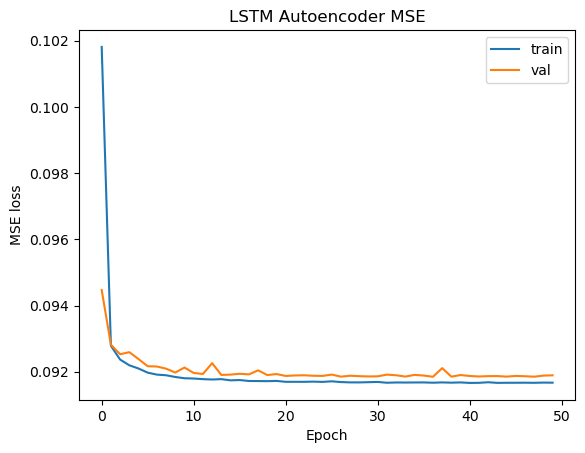

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 01 | Train MSE: 0.1058 | Val MSE: 0.0941
Epoch 02 | Train MSE: 0.0928 | Val MSE: 0.0924
Epoch 03 | Train MSE: 0.0922 | Val MSE: 0.0923
Epoch 04 | Train MSE: 0.0920 | Val MSE: 0.0922
Epoch 05 | Train MSE: 0.0919 | Val MSE: 0.0921
Epoch 06 | Train MSE: 0.0919 | Val MSE: 0.0921
Epoch 07 | Train MSE: 0.0919 | Val MSE: 0.0921
Epoch 08 | Train MSE: 0.0918 | Val MSE: 0.0920
Epoch 09 | Train MSE: 0.0918 | Val MSE: 0.0921
Epoch 10 | Train MSE: 0.0918 | Val MSE: 0.0919
Epoch 11 | Train MSE: 0.0918 | Val MSE: 0.0920
Epoch 12 | Train MSE: 0.0918 | Val MSE: 0.0920
Epoch 13 | Train MSE: 0.0918 | Val MSE: 0.0920
Epoch 14 | Train MSE: 0.0917 | Val MSE: 0.0920
Epoch 15 | Train MSE: 0.0917 | Val MSE: 0.0920
Epoch 16 | Train MSE: 0.0917 | Val MSE: 0.0920
Epoch 17 | Train MSE: 0.0917 | Val MSE: 0.0920
Epoch 18 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 19 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 20 | Train MSE: 0.0917 | Val MSE: 0.0920
Epoch 21 | Train MSE: 0.0917 | Val MSE: 0.0919
Epoch 22 | Tr

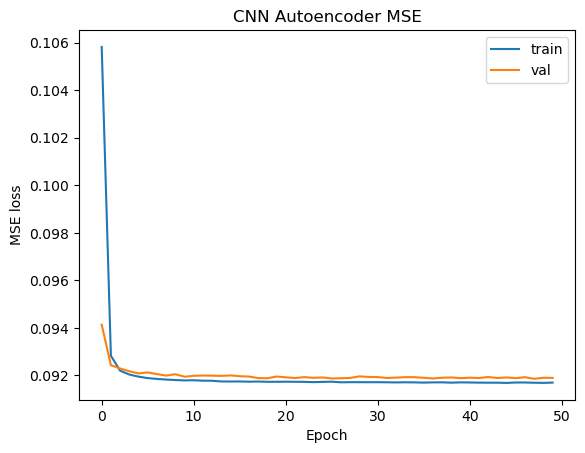

In [18]:
if __name__ == "__main__":
    # call lstm
    lstm_ae = LSTMVariationalAutoencoder(hidden_dim=128, num_layers=3, latent_dim=32)
    lstm_ae, history_lstm = train_autoencoder(lstm_ae, train_loader, val_loader, num_epochs=50)
    plot_loss(history_lstm, "LSTM Autoencoder MSE")

    # call conv autoencoder
    conv_ae = ConvVariationalAutoencoder(latent_dim=64)
    conv_ae, history_conv = train_autoencoder(conv_ae, train_loader, val_loader, num_epochs=50)
    plot_loss(history_conv, "CNN Autoencoder MSE")

In [ ]:
# Add this to the end of your code
import torchmetrics
from torchvision.utils import make_grid
import torchvision.transforms as T


def prepare_images_for_metric(x):
    x = F.interpolate(x, size=(299, 299), mode="bilinear", align_corners=False)
    x = x.repeat(1, 3, 1, 1)
    return x

def show_images(images, title):
    images = images[:36]
    grid = make_grid(images, nrow=6, padding=2, normalize=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    plt.axis("off")
    plt.title(title)
    plt.show()

def generate_samples(model, num_samples=64): # Remove latent_dim from args or make it optional
    model.eval()
    device = next(model.parameters()).device # Get model's device

    # Infer latent_dim
    if hasattr(model, 'latent_dim'):
        ld = model.latent_dim
    elif hasattr(model, 'fc_mu') and hasattr(model.fc_mu, 'out_features'): # For ConvVAE, LSTMVAE
        ld = model.fc_mu.out_features
    elif hasattr(model, 'fc_dec') and hasattr(model.fc_dec, 'in_features'): # Fallback for decoder input
        # This might be latent_dim + conditional_dim for conditional models, so be careful
        # For non-conditional VAEs here, fc_dec.in_features is latent_dim
        ld = model.fc_dec.in_features # This assumes fc_dec directly takes latent vector z
    else:
        raise ValueError("Cannot automatically infer latent_dim from the model.")

    with torch.no_grad():
        z = torch.randn(num_samples, ld).to(device)
        samples = model.decode(z)
    return samples

# Generate samples
samples_lstm = generate_samples(lstm_ae)
samples_conv = generate_samples(conv_ae)

show_images(samples_lstm, "Generated Samples - LSTM VAE")
show_images(samples_conv, "Generated Samples - Conv VAE")

# IS and FID
is_metric = torchmetrics.image.inception.InceptionScore(normalize=True)
fid_metric = torchmetrics.image.fid.FrechetInceptionDistance(normalize=True)

real_imgs = torch.from_numpy(train_images[:2048])
real_imgs = prepare_images_for_metric(real_imgs)

for name, samples in [("LSTM", samples_lstm), ("Conv", samples_conv)]:
    gen_imgs = prepare_images_for_metric(samples[:2048])
    is_metric.reset()
    is_metric.update(gen_imgs)
    is_mean, is_std = is_metric.compute()
    print(f"Inception Score ({name} VAE): {is_mean:.3f} ± {is_std:.3f}")

    fid_metric.reset()
    fid_metric.update(real_imgs, real=True)
    fid_metric.update(gen_imgs, real=False)
    fid_score = fid_metric.compute()
    print(f"FID ({name} VAE): {fid_score:.3f}")

# Class ID mapping
rabbit_class_id = 0
yoga_class_id = 1
snowman_class_id = 3

# Subset creation
subset_mask = np.isin(train_labels, [rabbit_class_id, yoga_class_id, snowman_class_id])
subset_images = train_images[subset_mask]
subset_labels = train_labels[subset_mask]
label_map = {rabbit_class_id: 0, yoga_class_id: 1, snowman_class_id: 2}
subset_labels = np.array([label_map[l] for l in subset_labels])

# Conditional Conv VAE with label projection
class ConditionalConvVAE(nn.Module):
    def __init__(self, latent_dim=32, num_classes=3):
        super().__init__()
        self.label_proj = nn.Linear(num_classes, 32)

        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, 3, stride=2),
            nn.ReLU(True),
        )
        self.fc_mu = nn.Linear(64 * 3 * 3 + 32, latent_dim)
        self.fc_logvar = nn.Linear(64 * 3 * 3 + 32, latent_dim)

        self.fc_dec = nn.Linear(latent_dim + 32, 64 * 3 * 3)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x, y):
        h = self.encoder_cnn(x).view(x.size(0), -1)
        y_proj = self.label_proj(y)
        h_cat = torch.cat([h, y_proj], dim=1)
        return self.fc_mu(h_cat), self.fc_logvar(h_cat)

    def decode(self, z, y):
        y_proj = self.label_proj(y)
        z_cat = torch.cat([z, y_proj], dim=1)
        h = self.fc_dec(z_cat).view(z.size(0), 64, 3, 3)
        return self.decoder(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        return mu + torch.randn_like(std) * std

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar, z

# Conditional LSTM VAE with label projection
class ConditionalLSTMVAE(nn.Module):
    def __init__(self, hidden_dim=128, num_layers=2, latent_dim=32, num_classes=3):
        super().__init__()
        self.seq_len = 28
        self.input_dim = 28
        self.latent_dim = latent_dim
        self.label_proj = nn.Linear(num_classes, 32)

        self.encoder_lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.fc_mu = nn.Linear(hidden_dim + 32, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim + 32, latent_dim)

        self.fc_dec = nn.Linear(latent_dim + 32, hidden_dim)
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=self.input_dim,
            num_layers=num_layers,
            batch_first=True,
        )

    def encode(self, x, y):
        x_seq = x.squeeze(1)
        out, (h_n, _) = self.encoder_lstm(x_seq)
        y_proj = self.label_proj(y)
        h_cat = torch.cat([h_n[-1], y_proj], dim=1)
        return self.fc_mu(h_cat), self.fc_logvar(h_cat)

    def reparameterize(self, mu, logvar):
        std = torch.exp(logvar / 2)
        return mu + torch.randn_like(std) * std

    def decode(self, z, y):
        y_proj = self.label_proj(y)
        z_cat = torch.cat([z, y_proj], dim=1)
        dec_init = self.fc_dec(z_cat).unsqueeze(1).repeat(1, self.seq_len, 1)
        out, _ = self.decoder_lstm(dec_init)
        return out.reshape(z.size(0), 1, 28, 28)

    def forward(self, x, y):
        mu, logvar = self.encode(x, y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar, z

# Train conditional models
cond_conv_vae = ConditionalConvVAE(latent_dim=32, num_classes=3)
cond_lstm_vae = ConditionalLSTMVAE(latent_dim=32, num_classes=3)

subset_ds = TensorDataset(torch.from_numpy(subset_images), torch.from_numpy(subset_labels))
subset_loader = DataLoader(subset_ds, batch_size=BATCH_SIZE, shuffle=True)

def train_conditional(model, loader, epochs=20):
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    # Assuming num_classes can be inferred or is fixed (e.g., 3 for this script)
    # It's better to get num_classes from the model if possible, e.g., model.label_proj.in_features
    num_classes = 3 # Based on subset_labels and Conditional VAE initializations

    for epoch in tqdm(range(epochs)):
        model.train()
        for x, y in loader:
            # Move data to the model's device (important if using GPU)
            device = next(model.parameters()).device
            x = x.to(device)
            y = y.to(device)

            # Convert y to one-hot
            y_onehot = F.one_hot(y, num_classes=num_classes).float()

            recon, mu, logvar, _ = model(x, y_onehot)
            loss, _, _ = vae_loss(x, recon, mu, logvar)
            opt.zero_grad()
            loss.backward()
            opt.step()
    return model

cond_conv_vae = train_conditional(cond_conv_vae, subset_loader)
cond_lstm_vae = train_conditional(cond_lstm_vae, subset_loader)

for model, tag in [(cond_conv_vae, "Cond Conv"), (cond_lstm_vae, "Cond LSTM")]:
    for label, name in enumerate(["rabbit", "yoga", "snowman"]):
        y = torch.eye(3)[label].repeat(5, 1)
        z = torch.randn(5, 32)
        samples = model.decode(z, y).cpu()
        show_images(samples, f"{tag} Samples: {name}")

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x32 and 64x576)